In [ ]:
# Chase Abram
# IO 2 2021 with Hortacsu

In [56]:
using CSV
using DataFrames
using ForwardDiff
using LinearAlgebra
using Optim

using Random
using Statistics

using Plots

# Load data
df = DataFrame()
df = CSV.read("psetTwo.csv", DataFrame)

,milage
,Int64
1,23
2,31
3,36
4,46
5,56
6,66
7,75
8,85
9,86


In [9]:
# Mileage
mileage = df.milage
N = length(mileage)

# Find replacement periods
d_rep = [0; (mileage[2:N] - mileage[1:N-1]) .< 0]

5000-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

In [52]:
# Discretize the domain (equispacing)
function disc_domain(data, K)
    M = maximum(data)
    m = minimum(data)
    return LinRange(m,M,K)
end

# Map value to its chunk
function to_chunk(vs, chunks)
    
    its = zeros(length(vs))
    for j in 1:length(vs)
        it = 1
        while vs[j] > chunks[it] && it < length(chunks)
            it += 1
        end
        its[j] = it
    end
    return Int64.(its)
end

# Create transition matrices
function trans_mats(m, d, K)
    disc = disc_domain(m, K)
    
    
    rep = zeros(K,K)
    no_rep = zeros(K,K)
    
    for i in 2:length(m)
        if d[i]
            rep[to_chunk(m[i-1]), to_chunk(m[i])] += 1
        else
            no_rep[to_chunk(m[i-1]), to_chunk(m[i])] += 1
        end
    end
    
    # Normalize
    rep = rep*(1 ./sum(rep,dims=2))
    no_rep = no_rep*(1 ./sum(no_rep,dims=2))
    
    return rep, no_rep
end

trans_mats (generic function with 1 method)

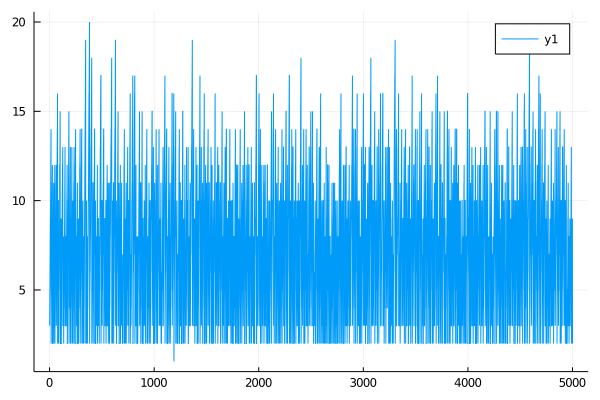

In [64]:
K = 20

disc = disc_domain(mileage, K)

to_chunk(mileage, disc)

# plot(to_chunk(mileage, disc))